<a href="https://colab.research.google.com/github/erantala1/Generative-Weather-Forecasting/blob/main/UNET_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install netCDF4
import torch
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from google.colab import drive


drive.mount('/content/drive')
data_79 = nc.Dataset('/content/drive/MyDrive/Copy of z1979.nc')
data_80 = nc.Dataset('/content/drive/MyDrive/Copy of z1980.nc')
data_81 = nc.Dataset('/content/drive/MyDrive/Copy of z1981.nc')
data_85 = nc.Dataset('/content/drive/MyDrive/Copy of z1985.nc')
data_83 = nc.Dataset('/content/drive/MyDrive/Copy of z1983.nc')

z_data_79 = torch.tensor(data_79.variables['z'][:],dtype=torch.float32)
z_data_80 = torch.tensor(data_80.variables['z'][:],dtype=torch.float32)
z_data_81 = torch.tensor(data_81.variables['z'][:],dtype=torch.float32)
z_data_83 = torch.tensor(data_83.variables['z'][:],dtype=torch.float32)
z_data_85 = torch.tensor(data_85.variables['z'][:],dtype=torch.float32)
print(z_data_79.shape)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 61.2 MB/s eta 0:00:00
Mounted at /content/drive
torch.Size([1460, 2, 91, 180])


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class LinearNoiseScheduler():
  def __init__(self, beta_start, beta_end, timesteps, device):
    self.beta_start = beta_start
    self.beta_end = beta_end
    self.timesteps = timesteps
    self.betas = torch.linspace(beta_start,beta_end,timesteps, device=device)
    self.alphas = 1. - self.betas
    self.alpha_product = torch.cumprod(self.alphas,dim=0)
    self.sqrt_alpha_cum_prod = torch.sqrt(self.alpha_product)
    self.sqrt_one_minus_alpha_cum_prod = torch.sqrt(1-self.alpha_product)
    self.device = device

  def add_noise(self,data,noise,t):
    data_shape = data.shape
    batch_size = data_shape[0]
    sqrt_alpha_cum_prod = self.sqrt_alpha_cum_prod[t].reshape(batch_size)
    sqrt_one_minus_alpha_cum_prod = self.sqrt_one_minus_alpha_cum_prod[t].reshape(batch_size)
    for _ in range(len(data_shape) - 1):
        sqrt_alpha_cum_prod = sqrt_alpha_cum_prod.unsqueeze(-1)
        sqrt_one_minus_alpha_cum_prod = sqrt_one_minus_alpha_cum_prod.unsqueeze(-1)
    return (sqrt_alpha_cum_prod * data + sqrt_one_minus_alpha_cum_prod * noise)

  def sample_prev_timestep(self, xt, noise_pred, t):

        alpha_cum_prod = self.alpha_product

        x0 = ((xt - (self.sqrt_one_minus_alpha_cum_prod[t].to(xt.device) * noise_pred)) /
              torch.sqrt(alpha_cum_prod[t]))
        x0 = torch.clamp(x0, -1., 1.)

        mean = xt - ((self.betas[t].to(xt.device)) * noise_pred) / (self.sqrt_one_minus_alpha_cum_prod[t].to(xt.device))
        mean = mean / torch.sqrt(self.alphas[t].to(xt.device))

        if t == 0:
            return mean, x0
        else:
            variance = (1 - alpha_cum_prod[t - 1]) / (1.0 - alpha_cum_prod[t])
            variance = variance * self.betas.to(xt.device)[t]
            sigma = variance ** 0.5
            z = torch.randn(xt.shape).to(xt.device)
            return mean + sigma * z, x0

In [ ]:
import math
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


In [ ]:
class Diffusion(nn.Module):
    def __init__(self, out_channels=2, time_embed_dim=128):
        super(Diffusion, self).__init__()

        self.time_embed = nn.Sequential(
            SinusoidalPositionEmbeddings(time_embed_dim),
            nn.Linear(time_embed_dim, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
            nn.SiLU()
        )

        self.cond_encoder = nn.Sequential(
            nn.Conv2d(2, 32, kernel_size=5, padding=2),
            nn.GroupNorm(8, 32),
            nn.SiLU(),
            nn.Conv2d(32, 32, kernel_size=5, padding=2),
            nn.GroupNorm(8, 32),
            nn.SiLU()
        )

        self.init_conv = nn.Conv2d(2 + 32, 32, kernel_size=5, padding=2)
        self.attn1 = SimpleResBlock(64)
        self.attn2 = SimpleResBlock(128)
        self.attn3 = SimpleResBlock(256)

        self.down1 = ResConvBlock(32, 64, time_embed_dim)
        self.down2 = ResConvBlock(64, 128, time_embed_dim)
        self.down3 = ResConvBlock(128, 256, time_embed_dim)

        self.mid1 = ResConvBlock(256, 256, time_embed_dim)
        self.mid_attn = SimpleResBlock(256)
        self.mid2 = ResConvBlock(256, 256, time_embed_dim)

        self.up3 = ResConvBlock(256 + 256, 128, time_embed_dim)
        self.up2 = ResConvBlock(128 + 128, 64, time_embed_dim)
        self.up1 = ResConvBlock(64 + 64, 32, time_embed_dim)

        self.final_block = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.GroupNorm(8, 32),
            nn.SiLU(),
            nn.Conv2d(32, 32, kernel_size=5, padding=2),
            nn.GroupNorm(8, 32),
            nn.SiLU()
        )

        self.final_conv = nn.Conv2d(32, out_channels, kernel_size=1)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x, t, cond):
        cond_features = self.cond_encoder(cond)
        x_cond = torch.cat([x, cond_features], dim=1)
        t_emb = self.time_embed(t)
        h = self.init_conv(x_cond)

        h1 = self.down1(h, t_emb)
        h1 = self.attn1(h1)
        h1_shape = h1.shape[-2:]

        h2 = self.down2(self.down_sample(h1), t_emb)
        h2 = self.attn2(h2)
        h2_shape = h2.shape[-2:]

        h3 = self.down3(self.down_sample(h2), t_emb)
        h3 = self.attn3(h3)
        h3_shape = h3.shape[-2:]

        h = self.mid1(self.down_sample(h3), t_emb)
        h = self.mid_attn(h)
        h = self.mid2(h, t_emb)

        h = F.interpolate(h, size=h3_shape, mode='bilinear', align_corners=False)
        h = torch.cat([h, h3], dim=1)
        h = self.up3(h, t_emb)

        h = F.interpolate(h, size=h2_shape, mode='bilinear', align_corners=False)
        h = torch.cat([h, h2], dim=1)
        h = self.up2(h, t_emb)

        h = F.interpolate(h, size=h1_shape, mode='bilinear', align_corners=False)
        h = torch.cat([h, h1], dim=1)
        h = self.up1(h, t_emb)

        h = self.final_block(h)
        return self.final_conv(h)

class ResConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_dim=None):
        super(ResConvBlock, self).__init__()
        self.time_mlp = nn.Linear(time_dim, out_channels) if time_dim else None

        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.norm1 = nn.GroupNorm(8, out_channels)
        self.act1 = nn.SiLU()

        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.norm2 = nn.GroupNorm(8, out_channels)
        self.act2 = nn.SiLU()

        self.residual = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x, t=None):
        residual = self.residual(x)

        h = self.conv1(x)
        h = self.norm1(h)
        h = self.act1(h)

        if t is not None and self.time_mlp is not None:
            time_emb = self.time_mlp(t)
            h = h + time_emb.unsqueeze(-1).unsqueeze(-1)

        h = self.conv2(h)
        h = self.norm2(h)
        h = h + residual
        h = self.act2(h)

        return h


class SimpleResBlock(nn.Module):
    def __init__(self, channels):
        super(SimpleResBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.norm1 = nn.GroupNorm(8, channels)
        self.act1 = nn.SiLU()
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
        self.norm2 = nn.GroupNorm(8, channels)
        self.act2 = nn.SiLU()

    def forward(self, x):
        residual = x
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.act2(x)
        return x + residual

In [ ]:
def normalize_data(data):
    mean = data.mean(dim=(0, 2, 3), keepdim=True)
    std = data.std(dim=(0, 2, 3), keepdim=True)
    return (data - mean) / (std + 1e-8), mean, std

def denormalize_data(data, mean, std):
    return data * (std + 1e-8) + mean

In [ ]:
model = Diffusion(out_channels=2, time_embed_dim=128)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
scheduler = LinearNoiseScheduler(beta_start=1e-4, beta_end=0.02, timesteps=100, device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.MSELoss()
epochs = 30
batch_size = 25
classifier_free_guidance_prob = 0.1
spatial_loss_weight = 0.1
model.to(device)
train_data = torch.cat([z_data_80, z_data_81, z_data_83], dim=0)
test_data = z_data_85
train_data_norm, mean, std = normalize_data(train_data)
test_data_norm = (test_data - mean) / (std + 1e-8)
num_timesteps = train_data.shape[0] - 1

def spatial_continuity_loss(pred):
    dx = pred[:, :, :, 1:] - pred[:, :, :, :-1]
    dy = pred[:, :, 1:, :] - pred[:, :, :-1, :]
    return (dx.pow(2).mean() + dy.pow(2).mean()) * spatial_loss_weight


training_losses = []
for epoch in range(epochs):
    model.train()
    total_loss = 0

    batch_indices = torch.randperm(num_timesteps)

    for i in range(0, num_timesteps, batch_size):
        optimizer.zero_grad()
        indices = batch_indices[i:min(i+batch_size, num_timesteps)]
        batch_size_actual = len(indices)

        x_t = train_data_norm[indices].to(device)
        x_t_plus_1 = train_data_norm[indices + 1].to(device)

        if torch.rand(1).item() < classifier_free_guidance_prob:
            zero_mask = torch.zeros_like(x_t)
            use_zeros = torch.rand(batch_size_actual) < 0.5

            for idx, use_zero in enumerate(use_zeros):
                if use_zero:
                    x_t[idx] = zero_mask[idx]

        t = torch.randint(0, scheduler.timesteps, (batch_size_actual,), device=device).long()
        noise = torch.randn_like(x_t_plus_1).to(device)
        noisy_x_t_plus_1 = scheduler.add_noise(x_t_plus_1, noise, t)
        noise_pred = model(noisy_x_t_plus_1, t, x_t)
        recon_loss = loss_fn(noise_pred, noise)
        spatial_loss = spatial_continuity_loss(noise_pred)
        loss = recon_loss + spatial_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item() * batch_size_actual

    avg_loss = total_loss / num_timesteps
    training_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}")

    if (epoch + 1) % 5 == 0:
        torch.save(model.state_dict(), f'weather_diffusion_model_epoch{epoch+1}.pth')

torch.save(model.state_dict(), 'weather_diffusion_model.pth')

Using device: cpu


In [ ]:
def make_prediction(model, scheduler, x_0, num_steps, device, mean, std):
    model.eval()
    x_0 = x_0.unsqueeze(0).to(device)
    predictions = [x_0.cpu()]
    current_x = x_0
    guidance_scales = [1.0, 2.5, 3.5, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5]
    denoising_strength = 0.4
    temporal_consistency = 0.8
    smoothing_sizes = [5, 7, 9, 11, 13, 13, 13, 13, 13, 13]
    smoothing_sigmas = [1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.0, 2.0, 2.0, 2.0]

    def apply_directional_consistency(x, prev_pred, prev_prev_pred=None):
        if prev_prev_pred is None:
            return x

        motion = prev_pred - prev_prev_pred
        momentum_factor = 0.3
        return x + motion * momentum_factor

    def create_gaussian_kernel(size, sigma):
        coords = torch.arange(size).float() - (size - 1) / 2
        coords = coords.view(1, -1).expand(size, -1)
        coords_y = coords.t()

        kernel = torch.exp(-(coords**2 + coords_y**2) / (2 * sigma**2))
        kernel = kernel / kernel.sum()
        kernel = kernel.view(1, 1, size, size).repeat(2, 1, 1, 1)
        return kernel.to(device)

    def apply_multi_scale_smoothing(x, step):
        size = smoothing_sizes[min(step, len(smoothing_sizes)-1)]
        sigma = smoothing_sigmas[min(step, len(smoothing_sigmas)-1)]
        kernel = create_gaussian_kernel(size, sigma)
        padded = F.pad(x, (size//2, size//2, size//2, size//2), mode='reflect')
        smoothed = F.conv2d(padded, kernel, groups=2)
        if step > 1:
            large_kernel = create_gaussian_kernel(size*2-1, sigma*2)
            large_padded = F.pad(x, (size-1, size-1, size-1, size-1), mode='reflect')
            large_smoothed = F.conv2d(large_padded, large_kernel, groups=2)
            smoothed = smoothed * 0.7 + large_smoothed * 0.3
        blend_factor = min(0.3 + step * 0.05, 0.6)
        return x * (1 - blend_factor) + smoothed * blend_factor

    history = [current_x]

    for step in range(num_steps):
        print(f"Generating prediction for step {step+1}/{num_steps}")

        current_x = apply_multi_scale_smoothing(current_x, step)
        steps_to_use = max(100 - step * 8, 50)
        step_indices = torch.linspace(0, scheduler.timesteps-1, steps_to_use).long()

        noise_scale = max(0.9 - step * 0.1, 0.3)
        x = torch.randn_like(current_x).to(device) * noise_scale

        if step > 0:
            prev_pred = predictions[-1].to(device)
            warm_start_weight = min(0.5 + step * 0.05, 0.8)
            x = x * (1 - warm_start_weight) + prev_pred * warm_start_weight

            if step > 1:
                prev_prev_pred = predictions[-2].to(device)
                x = apply_directional_consistency(x, prev_pred, prev_prev_pred)

        guidance = guidance_scales[min(step, len(guidance_scales)-1)]

        for i in reversed(step_indices):
            t = torch.full((1,), i, device=device, dtype=torch.long)

            with torch.no_grad():
                noise_pred_cond = model(x, t, current_x)
                empty_cond = torch.zeros_like(current_x)
                noise_pred_uncond = model(x, t, empty_cond)
                noise_pred = noise_pred_uncond + guidance * (noise_pred_cond - noise_pred_uncond)
                x, _ = scheduler.sample_prev_timestep(x, noise_pred, i)
                x = torch.clamp(x, -2.0, 2.0)
                smoothing_frequency = max(20 - step * 2, 5)
                if i % smoothing_frequency == 0:
                    x = apply_multi_scale_smoothing(x, step)

        x = apply_multi_scale_smoothing(x, step)
        predictions.append(x.cpu())
        history.append(x)

        if step > 0:
            blend_factor = temporal_consistency + min(step * 0.02, 0.1)
            current_x = x * (1 - blend_factor) + history[-2] * blend_factor
        else:
            current_x = x
        if len(history) > 3:
            history = history[-3:]

    predictions = torch.cat(predictions, dim=0).squeeze(1)
    predictions_denorm = denormalize_data(predictions, mean, std)

    return predictions_denorm

In [ ]:
def plot_predictions(predictions, ground_truth, steps_to_show=[0, 3, 7]):
    n_steps = len(steps_to_show)
    fig, axes = plt.subplots(4, n_steps, figsize=(n_steps*5, 12))

    for i, step in enumerate(steps_to_show):

        pred_data_ch1 = predictions[step, 0].numpy()
        pred_data_ch2 = predictions[step, 1].numpy()
        truth_data_ch1 = ground_truth[step, 0].numpy()
        truth_data_ch2 = ground_truth[step, 1].numpy()

        ax = axes[0, i]
        im = ax.contourf(pred_data_ch1, cmap='coolwarm')
        ax.set_title(f'Predicted Ch1 - Step {step}')
        plt.colorbar(im, ax=ax)

        ax = axes[1, i]
        im = ax.contourf(truth_data_ch1, cmap='coolwarm')
        ax.set_title(f'Ground Truth Ch1 - Step {step}')
        plt.colorbar(im, ax=ax)

        ax = axes[2, i]
        im = ax.contourf(pred_data_ch2, cmap='coolwarm')
        ax.set_title(f'Predicted Ch2 - Step {step}')
        plt.colorbar(im, ax=ax)

        ax = axes[3, i]
        im = ax.contourf(truth_data_ch2, cmap='coolwarm')
        ax.set_title(f'Ground Truth Ch2 - Step {step}')
        plt.colorbar(im, ax=ax)

    plt.tight_layout()
    plt.show()

Generating prediction for step 1/10


Diffusion:   0%|          | 0/100 [00:00<?, ?it/s]

Generating prediction for step 2/10


Diffusion:   0%|          | 0/92 [00:00<?, ?it/s]

Generating prediction for step 3/10


Diffusion:   0%|          | 0/84 [00:00<?, ?it/s]

Generating prediction for step 4/10


Diffusion:   0%|          | 0/76 [00:00<?, ?it/s]

Generating prediction for step 5/10


Diffusion:   0%|          | 0/68 [00:00<?, ?it/s]

Generating prediction for step 6/10


Diffusion:   0%|          | 0/60 [00:00<?, ?it/s]

Generating prediction for step 7/10


Diffusion:   0%|          | 0/52 [00:00<?, ?it/s]

Generating prediction for step 8/10


Diffusion:   0%|          | 0/50 [00:00<?, ?it/s]

Generating prediction for step 9/10


Diffusion:   0%|          | 0/50 [00:00<?, ?it/s]

Generating prediction for step 10/10


Diffusion:   0%|          | 0/50 [00:00<?, ?it/s]

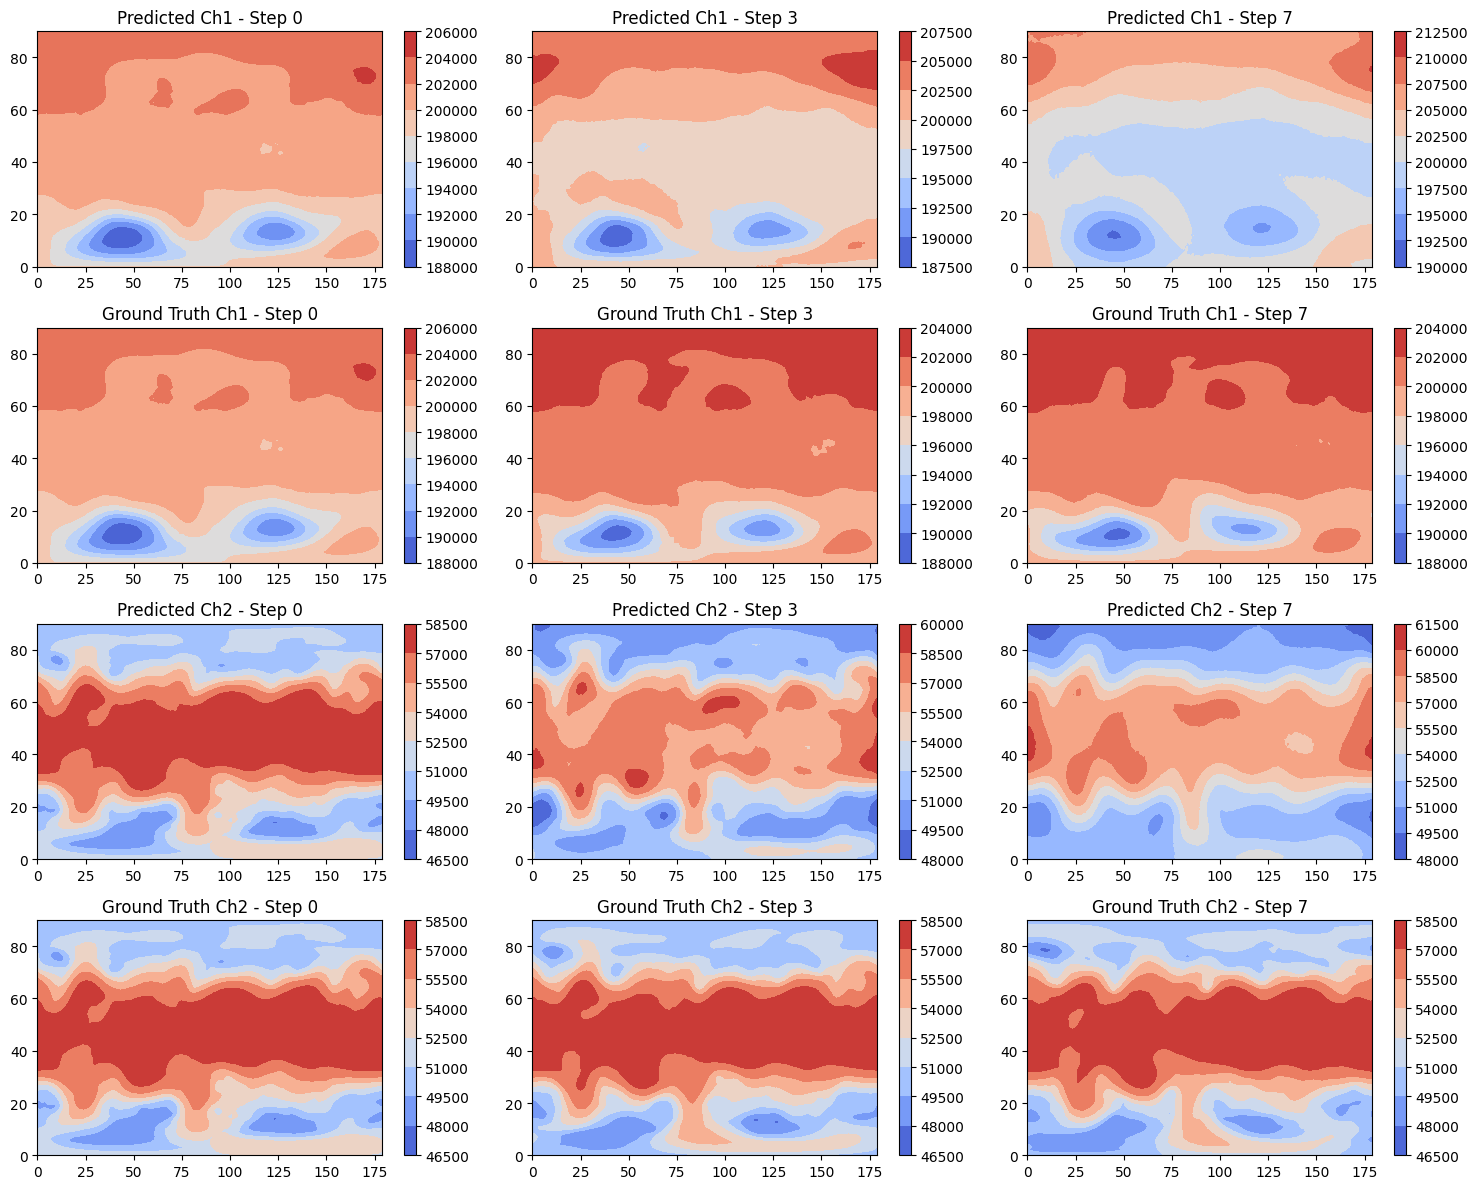

In [ ]:
model = Diffusion(out_channels=2, time_embed_dim=128)
model.load_state_dict(torch.load('weather_diffusion_model.pth'))
model.to(device)
x_0 = test_data_norm[0]
num_steps = 10

predictions_denorm = make_prediction(
    model=model,
    scheduler=scheduler,
    x_0=x_0,
    num_steps=num_steps,
    device=device,
    mean=mean,
    std=std
)
ground_truth = test_data[:11]
plot_predictions(predictions_denorm, ground_truth, steps_to_show=[0, 3, 7])

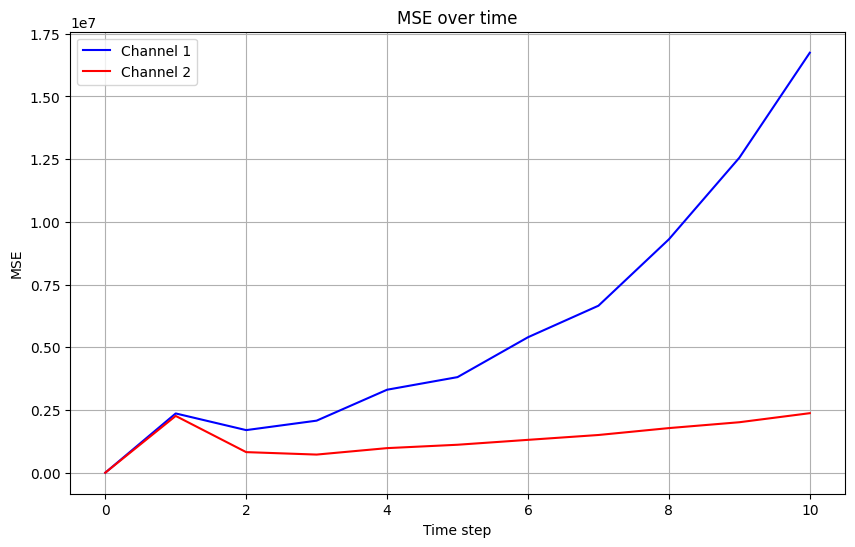

In [ ]:
mse_ch_1 = []
mse_ch_2 = []

for i in range(ground_truth.shape[0]):
    mse_1 = torch.mean((predictions_denorm[i, 0] - ground_truth[i, 0]) ** 2).item()
    mse_2 = torch.mean((predictions_denorm[i, 1] - ground_truth[i, 1]) ** 2).item()
    mse_ch_1.append(mse_1)
    mse_ch_2.append(mse_2)


plt.figure(figsize=(10, 6))
plt.plot(range(len(mse_ch_1)), mse_ch_1, 'b-', label='Channel 1')
plt.plot(range(len(mse_ch_2)), mse_ch_2, 'r-', label='Channel 2')
plt.xlabel('Time step')
plt.ylabel('MSE')
plt.title('MSE over time')
plt.legend()
plt.grid(True)
plt.show()